In [30]:
# Dependencies and Setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import shap
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
pd.set_option('display.max_columns', None)

dementia_df = pd.read_csv("../Resources/dementia_patients_health_data.csv")
dementia_df

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,Primary School,Left,Female,No,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,Secondary School,Right,Male,No,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,Primary School,Right,Male,Yes,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,Secondary School,Left,Female,Yes,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,Secondary School,Right,Male,Yes,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0.081825,87,93.851963,36.495134,50.380106,42.318663,Donepezil,10.0,88,Diploma/Degree,Left,Male,Yes,Never Smoked,Positive,Mild Activity,No,5,No,Balanced Diet,Poor,Diabetes,1
996,1,0.145249,97,94.522391,36.270804,94.006484,52.812568,NaN,NaN,80,Primary School,Left,Female,No,Never Smoked,Negative,Moderate Activity,No,9,Yes,Low-Carb Diet,Poor,Diabetes,0
997,1,0.073692,65,98.578388,37.065703,80.088613,13.640229,NaN,NaN,67,Primary School,Right,Female,No,Never Smoked,Positive,Sedentary,No,8,Yes,Balanced Diet,Good,Diabetes,0
998,0,0.037347,71,91.298580,37.037202,95.322210,17.445715,Memantine,20.0,62,No School,Left,Male,Yes,Never Smoked,Positive,Sedentary,Yes,2,No,Low-Carb Diet,Good,NaN,1


# Preprocessing the Data

In [3]:
# Drop unimportant 'Prescription' and 'Dosage in mg' columns and 'Cognitive_Test_Scores' column for this notebook
dementia_df.drop(columns=['Prescription', 'Dosage in mg', 'Cognitive_Test_Scores'], inplace=True)
dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,Primary School,Left,Female,No,Current Smoker,Negative,Sedentary,No,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,Secondary School,Right,Male,No,Former Smoker,Positive,Moderate Activity,No,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,Primary School,Right,Male,Yes,Former Smoker,Negative,Moderate Activity,No,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,Secondary School,Left,Female,Yes,Never Smoked,Negative,Mild Activity,Yes,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,Secondary School,Right,Male,Yes,Never Smoked,Positive,Mild Activity,No,Yes,Low-Carb Diet,Good,Diabetes,1


In [4]:
# Encoding the binary columns using a custom function
binary_cols = ["Dominant_Hand", "Gender", "Family_History", "APOE_ε4", "Depression_Status", "Medication_History", "Sleep_Quality"]

def encode_binary(bin):
    if bin in ("Left", "Female", "Yes", "Positive", "Good"):
        return 1
    else:
        return 0

# Call the encode_binary function on the binary columns
for col in binary_cols:
    dementia_df[col] = dementia_df[col].apply(encode_binary)
dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,Primary School,1,1,0,Current Smoker,0,Sedentary,0,0,Low-Carb Diet,0,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,Secondary School,0,0,0,Former Smoker,1,Moderate Activity,0,1,Low-Carb Diet,0,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,Primary School,0,0,1,Former Smoker,0,Moderate Activity,0,0,Mediterranean Diet,0,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,Secondary School,1,1,1,Never Smoked,0,Mild Activity,1,1,Balanced Diet,0,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,Secondary School,0,0,1,Never Smoked,1,Mild Activity,0,1,Low-Carb Diet,1,Diabetes,1


In [5]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_cols = dementia_df.columns.drop(labels=['Diabetic', 'AlcoholLevel', 'HeartRate', 'BloodOxygenLevel', 'BodyTemperature', 'Weight', 'MRI_Delay', 'Age', 'Dementia'] + binary_cols)
for col in categorical_cols:
    dementia_df = pd.concat([dementia_df, pd.get_dummies(dementia_df[col])], axis=1)
    dementia_df.drop(columns=col, inplace=True)

dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Dominant_Hand,Gender,Family_History,APOE_ε4,Depression_Status,Medication_History,Sleep_Quality,Dementia,Diploma/Degree,No School,Primary School,Secondary School,Current Smoker,Former Smoker,Never Smoked,Mild Activity,Moderate Activity,Sedentary,Balanced Diet,Low-Carb Diet,Mediterranean Diet,Diabetes,Heart Disease,Hypertension
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,1,1,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False,True,False,True,False,True,False,False
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,0,0,0,1,0,1,0,1,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,0,0,1,0,0,0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,1,1,1,0,1,1,0,1,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False,True
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,0,0,1,1,0,1,1,1,False,False,False,True,False,False,True,True,False,False,False,True,False,True,False,False


In [6]:
# Drop 'Diabetes' column as it duplicates the 'Diabetic' column
print(dementia_df[['Diabetic', 'Diabetes']].value_counts())
dementia_df.drop(columns='Diabetes', inplace=True)
dementia_df.head()

Diabetic  Diabetes
1         True        513
0         False       487
Name: count, dtype: int64


,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Dominant_Hand,Gender,Family_History,APOE_ε4,Depression_Status,Medication_History,Sleep_Quality,Dementia,Diploma/Degree,No School,Primary School,Secondary School,Current Smoker,Former Smoker,Never Smoked,Mild Activity,Moderate Activity,Sedentary,Balanced Diet,Low-Carb Diet,Mediterranean Diet,Heart Disease,Hypertension
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,1,1,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,0,0,0,1,0,1,0,1,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,0,0,1,0,0,0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,True,True,False
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,1,1,1,0,1,1,0,1,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,0,0,1,1,0,1,1,1,False,False,False,True,False,False,True,True,False,False,False,True,False,False,False


In [7]:
# Assign target variable and features
y = dementia_df['Dementia']
X = dementia_df.drop(columns='Dementia')

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [8]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Deep Learning Model

In [9]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu', 'leaky_relu'])
    activation_last = hp.Choice('activation_last',['sigmoid', 'tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=500,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 15)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=500,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_last))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [10]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    directory=os.path.normpath('C:/'),
    project_name='dementia_no_cognitive_test_keras_tuner',
    overwrite=True)

In [11]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 07s]
val_accuracy: 0.7639999985694885

Best val_accuracy So Far: 0.8080000281333923
Total elapsed time: 00h 03m 36s


In [12]:
# Get top 10 model hyperparameters and print the values
from pprint import pprint
top_hps = tuner.get_best_hyperparameters(10)
for param in top_hps:
    pprint(param.values)
    print('-'*40)

{'activation': 'leaky_relu',
 'activation_last': 'sigmoid',
 'first_units': 96,
 'num_layers': 1,
 'tuner/bracket': 1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 1,
 'tuner/trial_id': '0018',
 'units_0': 326,
 'units_1': 281,
 'units_10': 261,
 'units_11': 281,
 'units_12': 16,
 'units_13': 456,
 'units_14': 396,
 'units_2': 211,
 'units_3': 331,
 'units_4': 276,
 'units_5': 286,
 'units_6': 226,
 'units_7': 286,
 'units_8': 451,
 'units_9': 231}
----------------------------------------
{'activation': 'relu',
 'activation_last': 'sigmoid',
 'first_units': 466,
 'num_layers': 2,
 'tuner/bracket': 2,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 2,
 'tuner/trial_id': '0042',
 'units_0': 411,
 'units_1': 131,
 'units_10': 86,
 'units_11': 376,
 'units_12': 331,
 'units_13': 296,
 'units_14': 126,
 'units_2': 456,
 'units_3': 316,
 'units_4': 136,
 'units_5': 491,
 'units_6': 261,
 'units_7': 346,
 'units_8': 226,
 'units_9': 126}
--------------------

In [13]:
# Evaluate the top 3 models against the test dataset
top_models = tuner.get_best_models(3)
for model in top_models:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    print('-'*80)

8/8 - 0s - loss: 0.4415 - accuracy: 0.8080 - 183ms/epoch - 23ms/step
Loss: 0.44151610136032104, Accuracy: 0.8080000281333923
--------------------------------------------------------------------------------
8/8 - 0s - loss: 1.1220 - accuracy: 0.8080 - 212ms/epoch - 27ms/step
Loss: 1.121957540512085, Accuracy: 0.8080000281333923
--------------------------------------------------------------------------------
8/8 - 0s - loss: 0.4374 - accuracy: 0.7960 - 203ms/epoch - 25ms/step
Loss: 0.4374408423900604, Accuracy: 0.7960000038146973
--------------------------------------------------------------------------------


In [14]:
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                2976      
                                                                 
 dense_1 (Dense)             (None, 326)               31622     
                                                                 
 dense_2 (Dense)             (None, 1)                 327       
                                                                 
Total params: 34925 (136.43 KB)
Trainable params: 34925 (136.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Save the model's summary to a txt file (Uncomment if new model is generated)
# with open('best_model_summary.txt', 'w') as f:
#     with redirect_stdout(f):
#         best_model.summary()

In [16]:
#Predict
best_hps=tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train_scaled, y_train, epochs=50)

val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
24/24 [==============================] - 1s 2ms/step - loss: 0.5469 - accuracy: 0.7120
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3907 - accuracy: 0.7947
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8333
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3267 - accuracy: 0.8387
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3063 - accuracy: 0.8480
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2903 - accuracy: 0.8560
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8787
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.8813
Epoch 9/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.8987
Epoch 10/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.9093
Epoch 11/50
24/24 [

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = hypermodel.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 1.1153 - accuracy: 0.7640 - 124ms/epoch - 16ms/step
Loss: 1.1153310537338257, Accuracy: 0.7639999985694885


In [18]:
# Save the model to a h5 file (Uncomment if new model is generated)
# best_model.save('dementia_predictor.h5')

# Random Forest Model

In [19]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=3)

In [20]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [21]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [22]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [23]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,101,25
Actual 1,40,84


Accuracy Score : 0.74
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       126
           1       0.77      0.68      0.72       124

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250



In [24]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.21523552380837813, 'Depression_Status'),
 (0.11107583501902818, 'APOE_ε4'),
 (0.0656646418211438, 'BloodOxygenLevel'),
 (0.0652876199243048, 'BodyTemperature'),
 (0.06417228842845803, 'Weight'),
 (0.06329360000193457, 'MRI_Delay'),
 (0.059187730939496176, 'AlcoholLevel'),
 (0.052900619400865594, 'Age'),
 (0.0504921830809717, 'HeartRate'),
 (0.04268869617480959, 'Current Smoker'),
 (0.016072108459808172, 'Former Smoker'),
 (0.012720931615480411, 'No School'),
 (0.01270370022857787, 'Family_History'),
 (0.011943912249876312, 'Sleep_Quality'),
 (0.011918253961449209, 'Dominant_Hand'),
 (0.011147632115467685, 'Diploma/Degree'),
 (0.011081734182653248, 'Never Smoked'),
 (0.010808026298046695, 'Medication_History'),
 (0.010440472329364995, 'Hypertension'),
 (0.01038793828411618, 'Gender'),
 (0.010025378569318006, 'Mild Activity'),
 (0.00998474701203446, 'Diabetic'),
 (0.009600867083912114, 'Primary School'),
 (0.009350320147027922, 'Mediterranean Diet'),
 (0.009223949253925527, 'Low-Carb

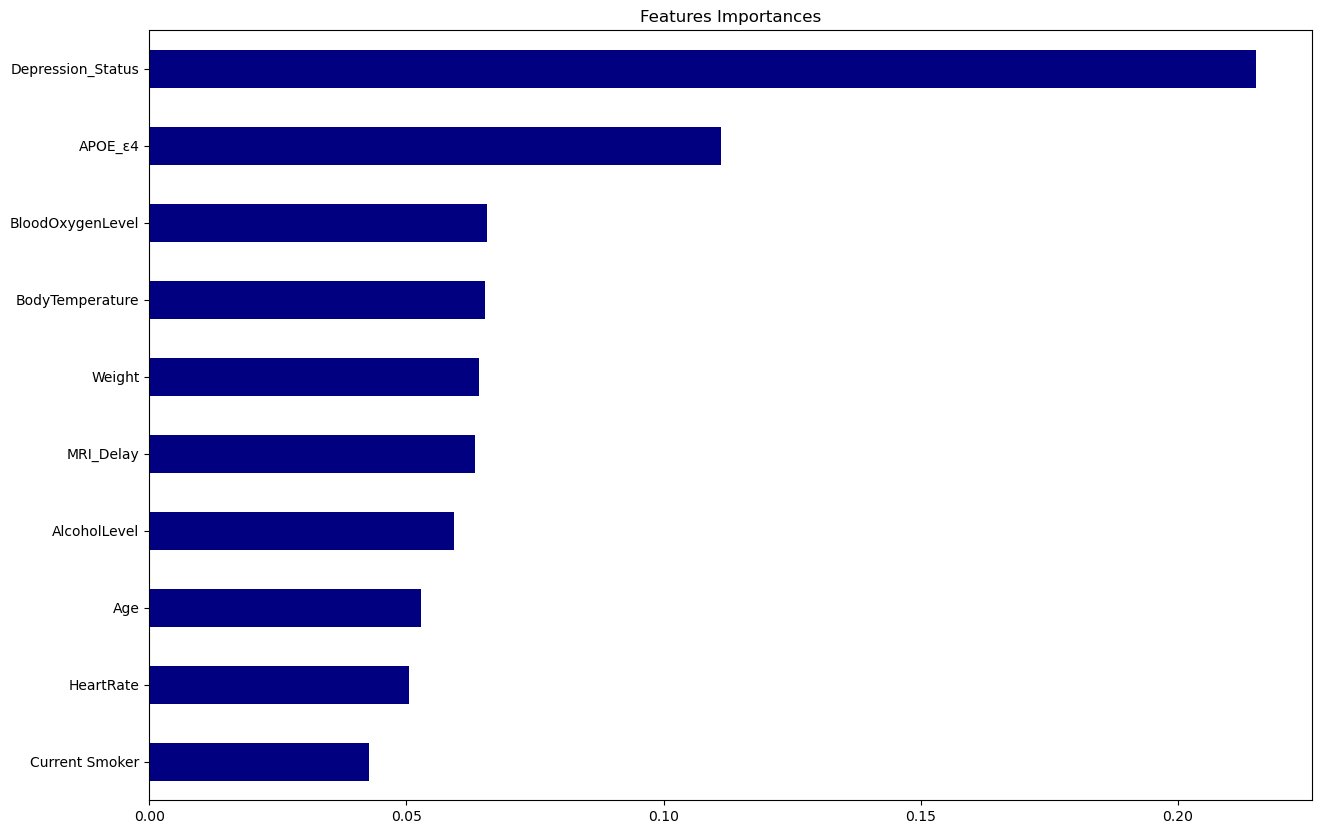

In [29]:
# Visualize the features by importance and save the graph as a JPG file
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances').tail(10)
importances_sorted.plot(kind='barh', color='navy', ylabel='', title= 'Features Importances', legend=False, figsize=(15,10)).get_figure().savefig('features_importances_no_cognitive_test_top10.jpg')

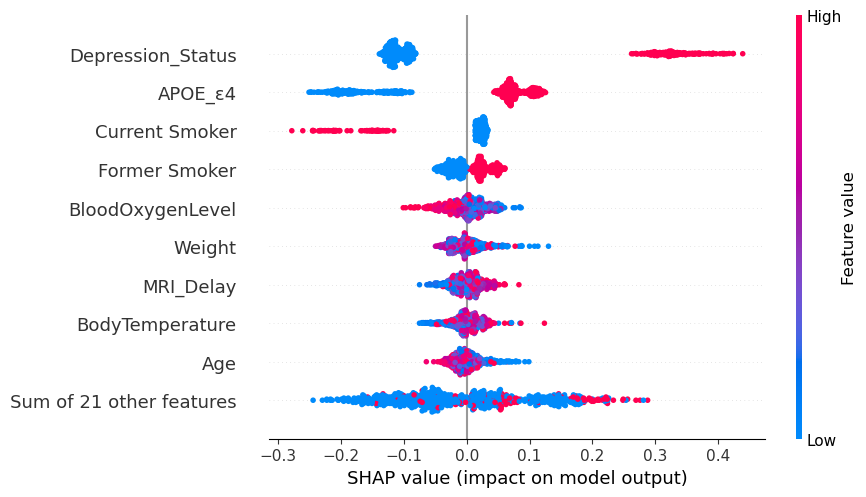

In [31]:
# Graph the SHAP values of the model with the explainer
explainer = shap.Explainer(rf_model, feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values[:,:,1])
plt.show()

# Logistic Regression Model

In [26]:
# Declare a logistic regression model
logistic_regression_model = LogisticRegression(random_state=3)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

In [27]:
# Generate predictions
lr_predictions = logistic_regression_model.predict(X_test_scaled)

# Create and save the confusion matrix for predictions
lr_matrix = confusion_matrix(y_test, lr_predictions)

# Print the confusion matrix for the predictions
lr_cm_df = pd.DataFrame(
    lr_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)

In [28]:
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,98,28
Actual 1,36,88


Accuracy Score : 0.744
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       126
           1       0.76      0.71      0.73       124

    accuracy                           0.74       250
   macro avg       0.74      0.74      0.74       250
weighted avg       0.74      0.74      0.74       250

